# Finding a Circuit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("/workspace/circuit-finder")

In [3]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"

# Import stuff
import torch as t
from torch import Tensor
import numpy as np
import einops
import eindex
from tqdm.notebook import tqdm_notebook
import plotly.express as px
import plotly.graph_objects as go
import webbrowser
import functools
import re
import itertools

from jaxtyping import Float, Int, Bool
from typing import List, Union, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
import copy

from IPython.display import display, HTML

from rich.table import Table, Column
from rich import print as rprint

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache, FactoredMatrix
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

def concat_lists(list_of_lists):
    return functools.reduce(lambda x, y: x+y, list_of_lists)

update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor"}

def imshow(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

def line(tensor: Union[t.Tensor, List[t.Tensor]], renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "xaxis_tickvals" in kwargs_pre:
        tickvals = kwargs_pre.pop("xaxis_tickvals")
        kwargs_post["xaxis"] = dict(
            tickmode = "array",
            tickvals = kwargs_pre.get("x", np.arange(len(tickvals))),
            ticktext = tickvals
        )
    y = utils.to_numpy(tensor) if isinstance(tensor, t.Tensor) else list(map(utils.to_numpy, tensor))
    px.line(y=y, **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def scatter(x, y, renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    add_line = None
    if "add_line" in kwargs:
        add_line = kwargs.pop("add_line")
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    fig = px.scatter(y=y, x=x, **kwargs_pre).update_layout(**kwargs_post)
    if add_line is not None:
        xrange = fig.layout.xaxis.range or [x.min(), x.max()]
        yrange = fig.layout.yaxis.range or [y.min(), y.max()]
        add_line = add_line.replace(" ", "")
        if add_line in ["x=y", "y=x"]:
            fig.add_trace(go.Scatter(mode='lines', x=xrange, y=xrange, showlegend=False))
        elif re.match("(x|y)=", add_line):
            try: c = float(add_line.split("=")[1])
            except: raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
            x, y = ([c, c], yrange) if add_line[0] == "x" else (xrange, [c, c])
            fig.add_trace(go.Scatter(mode='lines', x=x, y=y, showlegend=False))
        else:
            raise ValueError(f"Unrecognized add_line: {add_line}. Please use either 'x=y' or 'x=c' or 'y=c' for some float c.")
    fig.show(renderer)

def bar(tensor, renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    px.bar(y=utils.to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/accelerate/utils/imports.py:274: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [4]:
from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [40]:
import pickle
from circuit_finder.constants import ProjectDir
from circuit_finder.paper.run_leap_experiment_batched import LeapExperimentResult

def load_result(
    dataset_name: str, threshold: float, sweep_name: str
) -> LeapExperimentResult:
    save_dir = (
        ProjectDir
        / "results"
        / sweep_name
        / f"dataset={dataset_name}_threshold={threshold}"
    )

    with open(save_dir / "result.pkl", "rb") as file:
        result = pickle.load(file)

    return result

result = load_result("subject_verb_agreement", 0.003, "corrupt_keep_error")

In [41]:
import torch

batch = result.batch
print(batch)

clean_tokens = batch.clean
answer_tokens = torch.cat([batch.answers, batch.wrong_answers], dim=-1)
corrupted_tokens = batch.corrupt
print(answer_tokens.shape)

clean_str = model.to_string(clean_tokens[0])
answer_str = model.to_string(batch.answers[0])
wrong_answer_str = model.to_string(batch.wrong_answers[0])
corrupted_str = model.to_string(corrupted_tokens[0])

print(clean_str)
print(answer_str, answer_str.startswith(" "))
print(wrong_answer_str, wrong_answer_str.startswith(" "))
print(corrupted_str)

PromptPairBatch(key=7089124527981056992, batch_diverge_idx=4, clean=tensor([[50256, 50256, 50256,   464,  3730,  1474,   262,  7161]],
       device='cuda:0'), corrupt=tensor([[50256, 50256, 50256,   464,  3516,  1474,   262,  7161]],
       device='cuda:0'), answers=tensor([[423]], device='cuda:0'), wrong_answers=tensor([[468]], device='cuda:0'))
torch.Size([1, 2])
<|endoftext|><|endoftext|><|endoftext|>The guys near the bike
 have True
 has True
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike


# Neuron-Space Analysis

In [154]:
from transformer_lens import patching

In [155]:
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 2.5224
Corrupted logit diff: -3.2655


In [156]:
def normalized_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> float:
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    last_token_logits = logits[:, -1, :]
    correct_logit = eindex.eindex(last_token_logits, answer_tokens[:, 0], "batch [batch]")
    incorrect_logit = eindex.eindex(last_token_logits, answer_tokens[:, 1], "batch [batch]")
    logit_diff: Float[Tensor, "batch"] = correct_logit - incorrect_logit
    logit_diff = logit_diff.mean()

    return (logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

In [158]:
act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model = model,
    corrupted_tokens = corrupted_tokens,
    clean_cache = clean_cache,
    patching_metric = normalized_metric
)
print(act_patch_resid_pre.shape)

labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

  0%|          | 0/96 [00:00<?, ?it/s]

torch.Size([12, 8])


In [159]:
imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600
)

# Node Patching

In [160]:
from circuit_finder.core.types import get_node_name, parse_node_name, get_hook_name 

nodes_of_interest = {
    "1-mlp-7687": get_node_name("mlp", 1, 4, 7687),
    "3-mlp-20629": get_node_name("mlp", 3, 4, 20629),
    "5-mlp-12983": get_node_name("mlp", 5, 4, 12983),
    "5-mlp-8674": get_node_name("mlp", 5, 4, 8674),
    "6-mlp-7018": get_node_name("mlp", 6, 4, 7128),
    "9-mlp-623": get_node_name("mlp", 9, 4, 623),
    "10-attn-12719": get_node_name("attn", 10, 7, 12719),
    "10-mlp-12393": get_node_name("mlp", 10, 7, 12393),
    "11-attn-9392": get_node_name("attn", 11, 7, 9392),
    "11-mlp-23211": get_node_name("mlp", 11, 7, 23211)
}

In [161]:
labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

In [162]:
import torch
from circuit_finder.core.types import get_node_name, parse_node_name, get_hook_name 
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders, filter_sae_acts_and_errors


for name, node in nodes_of_interest.items():
    module_name, layer_idx, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_hook_name(module_name, layer_idx)

    # Compare the clean vs corrupt node act at every layer position. 
    with torch.no_grad():
        with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
            _, clean_sae_cache = model.run_with_cache(clean_tokens, names_filter = filter_sae_acts_and_errors)
            _, corrupt_sae_cache = model.run_with_cache(corrupted_tokens, names_filter = filter_sae_acts_and_errors)


    clean_node_act = clean_sae_cache[hook_name][0, :, feature_idx]
    corrupt_node_act = corrupt_sae_cache[hook_name][0, :, feature_idx]
    clean_node_val = clean_node_act[token_idx].item()
    corrupt_node_val = corrupt_node_act[token_idx].item()

    stacked_acts = torch.stack([clean_node_act, corrupt_node_act], dim = 0)

    imshow(
        stacked_acts,
        x = labels, 
        # labels={"y": "Layer", "x": "Head"},
        title=f"Clean vs Corrupt Activation for node {node}",
        width=600
    )


In [163]:
def logits_to_ave_logit_diff(logits: Float[Tensor, "batch seq d_vocab"], answer_tokens: Float[Tensor, "batch 2"], per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''
    last_token_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    correct_logits = eindex.eindex(last_token_logits, answer_tokens[:, 0], "batch [batch]")
    incorrect_logits = eindex.eindex(last_token_logits, answer_tokens[:, 1], "batch [batch]")

    logits: Float[Tensor, "batch"] = correct_logits - incorrect_logits
    if per_prompt:
      return logits
    else:
      return logits.mean()

In [164]:
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 2.5224
Corrupted logit diff: -3.2655


In [165]:
def normalized_metric(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> float:
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    last_token_logits = logits[:, -1, :]
    correct_logit = eindex.eindex(last_token_logits, answer_tokens[:, 0], "batch [batch]")
    incorrect_logit = eindex.eindex(last_token_logits, answer_tokens[:, 1], "batch [batch]")
    logit_diff: Float[Tensor, "batch"] = correct_logit - incorrect_logit
    logit_diff = logit_diff.mean()

    return (logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

In [166]:
def patch_hook(act, hook, token_idx, feature_idx, value):
    act[:, token_idx, feature_idx] = value
    return act


def get_node_patching_plot(node, model, tokens, values):
    metrics = []
    module_name, layer_idx, token_idx, feature_idx = parse_node_name(node)
    hook_name = get_hook_name(module_name, layer_idx)
    with torch.no_grad():
        with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
            for value in values:
                hook_fn = partial(
                    patch_hook,
                    token_idx=token_idx,
                    feature_idx=feature_idx,
                    value=value,
                )
                with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):
                    patched_logits = model(tokens)
                    metric = normalized_metric(patched_logits)
                    metrics.append(metric.item())

    return values, metrics

In [167]:
results = {}

for name, node in nodes_of_interest.items():
    values, metrics = get_node_patching_plot(node, model, corrupted_tokens, np.arange(10) * 10)
    results[name] = (values, metrics)

<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike


Text(0.5, 0.98, 'Activation patching on corrupt prompt')

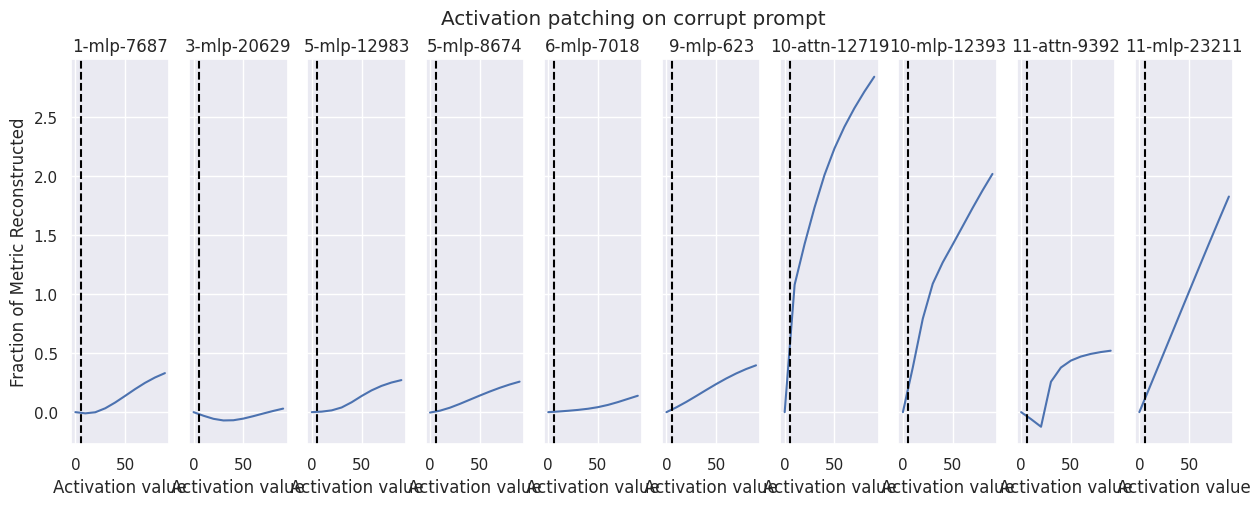

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, axs = plt.subplots(nrows = 1, ncols = len(results), figsize = (15, 5), sharey=True)
for (name, (values, metrics)), ax in zip(results.items(), axs):
    sns.lineplot(x = values, y = metrics, ax = ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Activation value")
    ax.set_ylabel("Fraction of Metric Reconstructed")
    ax.axvline(clean_node_val, ls = '--', color='black')
    print(corrupted_str)
fig.suptitle("Activation patching on corrupt prompt")

In [169]:
results = {}

for name, node in nodes_of_interest.items():
    values, metrics = get_node_patching_plot(node, model, clean_tokens, -np.arange(10) * 10)
    results[name] = (values, metrics)

<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike
<|endoftext|><|endoftext|><|endoftext|>The guy near the bike


Text(0.5, 0.98, 'Activation patching on clean prompt')

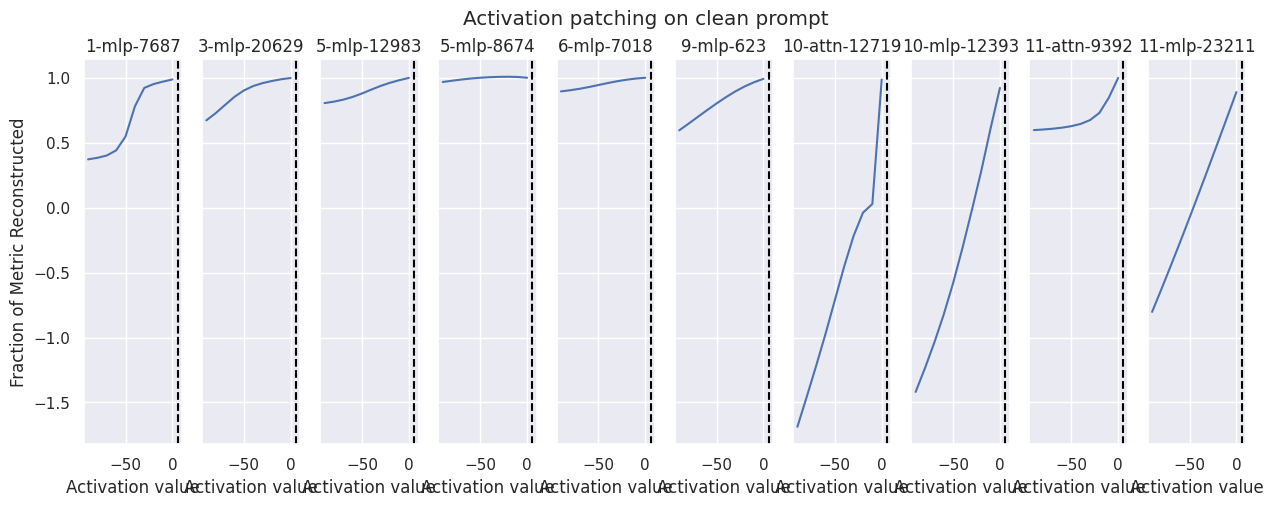

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

fig, axs = plt.subplots(nrows = 1, ncols = len(results), figsize = (15, 5), sharey=True)
for (name, (values, metrics)), ax in zip(results.items(), axs):
    sns.lineplot(x = values, y = metrics, ax = ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Activation value")
    ax.set_ylabel("Fraction of Metric Reconstructed")
    ax.axvline(clean_node_val, ls = '--', color='black')
    print(corrupted_str)
fig.suptitle("Activation patching on clean prompt")

# Node Attribution Breakdown

For a given upstream node and downstream node, we want to compare the size of the effect that goes through the node

In [171]:
from circuit_finder.patching.gradient_cache import (
    get_gradient_cache,
    patch_model_gradients_from_cache,
)

torch.set_grad_enabled(True)



def grad_metric_fn(model, tokens):
    logits = model(tokens)
    return logits_to_ave_logit_diff(logits, answer_tokens)

orig_grad_cache = get_gradient_cache(model, clean_tokens, grad_metric_fn)
with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
    with patch_model_gradients_from_cache(model, orig_grad_cache):
        grad_cache = get_gradient_cache(model, clean_tokens, grad_metric_fn, names_filter = filter_sae_acts_and_errors)

print(grad_cache)

torch.set_grad_enabled(False)

# Get the node cache

with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, names_filter = filter_sae_acts_and_errors)
    _, corrupted_cache = model.run_with_cache(corrupted_tokens, names_filter = filter_sae_acts_and_errors)

clean_metric = grad_metric_fn(model, clean_tokens)

ActivationCache with keys ['blocks.11.mlp.hook_sae_error', 'blocks.11.mlp.transcoder.hook_sae_acts_post', 'blocks.11.attn.hook_z.hook_sae_error', 'blocks.11.attn.hook_z.hook_sae_acts_post', 'blocks.10.mlp.hook_sae_error', 'blocks.10.mlp.transcoder.hook_sae_acts_post', 'blocks.10.attn.hook_z.hook_sae_error', 'blocks.10.attn.hook_z.hook_sae_acts_post', 'blocks.9.mlp.hook_sae_error', 'blocks.9.mlp.transcoder.hook_sae_acts_post', 'blocks.9.attn.hook_z.hook_sae_error', 'blocks.9.attn.hook_z.hook_sae_acts_post', 'blocks.8.mlp.hook_sae_error', 'blocks.8.mlp.transcoder.hook_sae_acts_post', 'blocks.8.attn.hook_z.hook_sae_error', 'blocks.8.attn.hook_z.hook_sae_acts_post', 'blocks.7.mlp.hook_sae_error', 'blocks.7.mlp.transcoder.hook_sae_acts_post', 'blocks.7.attn.hook_z.hook_sae_error', 'blocks.7.attn.hook_z.hook_sae_acts_post', 'blocks.6.mlp.hook_sae_error', 'blocks.6.mlp.transcoder.hook_sae_acts_post', 'blocks.6.attn.hook_z.hook_sae_error', 'blocks.6.attn.hook_z.hook_sae_acts_post', 'blocks.5.m

In [172]:


from circuit_finder.core.types import Node
from circuit_finder.patching.ablate import get_node_act

def get_node_attrib_breakdown(
    src_node: Node, 
    dest_nodes: list[Node], 
    model, 
    clean_tokens, 
    grad_cache, 
    clean_cache, 
    corrupt_cache,
):
    """ 
    Given a source node and a list of downstream nodes, 
    compute the breakdown of the source attrib through various downstream nodes
    
    Do this by just activation patching the src node, observing the change in dest nodes, 
    and multiplying this by the dest grad.
    """
    with torch.no_grad():
        with splice_model_with_saes_and_transcoders(model, transcoders, attn_saes):
            module_name, layer_idx, token_idx, feature_idx = parse_node_name(src_node)
            src_clean_value = get_node_act(clean_cache, src_node)
            src_corrupt_value = get_node_act(corrupt_cache, src_node)            

            dest_clean_values = {}
            for node in dest_nodes:
                if "metric" in node:
                    dest_clean_values[node] = clean_metric
                else:
                    dest_clean_values[node] = get_node_act(clean_cache, node) 

            # Activation patch the src node
            hook_name = get_hook_name(module_name, layer_idx)
            hook_fn = partial(
                patch_hook,
                token_idx=token_idx,
                feature_idx=feature_idx,
                value=src_corrupt_value,
            )
            with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):
                patched_logits, patched_cache = model.run_with_cache(clean_tokens)
                patched_metric = logits_to_ave_logit_diff(patched_logits, answer_tokens)

            # Record the change in edge nodes
            dest_patched_values = {}
            for node in dest_nodes:
                if "metric" in node:
                    dest_patched_values[node] = patched_metric
                else:
                    dest_patched_values[node] = get_node_act(patched_cache, node) 

        dest_grads = {}
        for node in dest_nodes:
            if "metric" in node:
                dest_grads[node] = 1
            else:
                dest_grads[node] = get_node_act(grad_cache, node)

    partial_attribs = {}
    for node in dest_nodes:
        partial_attrib = dest_grads[node] * (dest_clean_values[node] - dest_patched_values[node])
        partial_attribs[node] = partial_attrib.item()

    total_attrib = (src_clean_value - src_corrupt_value) * get_node_act(grad_cache, src_node)
    explained_attrib = sum(partial_attribs.values())

    partial_attribs["other"] = (total_attrib - explained_attrib).item()
    return partial_attribs

In [173]:
# Convert the graph to a dataframe

import pandas as pd 
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info, edge_type in result.graph.graph:
    (dest, src) = edge
    if dest == "null": continue
    (node_node_attr, node_node_grad, edge_metric_attr, edge_metric_grad) = edge_info

    src_module_name, src_layer, src_token_idx, src_feature_idx = parse_node_name(src)    
    dest_module_name, dest_layer, dest_token_idx, dest_feature_idx = parse_node_name(dest)

    rows.append({
        "src_module_name": src_module_name,
        "src_layer": src_layer,
        "src_token_idx": src_token_idx,
        "src_feature_idx": src_feature_idx,
        "dest_module_name": dest_module_name,
        "dest_layer": dest_layer,
        "dest_token_idx": dest_token_idx,
        "dest_feature_idx": dest_feature_idx,
        "edge_metric_attr": edge_metric_attr,
        "edge_metric_grad": edge_metric_grad,
        "node_node_attr": node_node_attr,
        "node_node_grad": node_node_grad,
        "edge_type": edge_type
    }) 

df = pd.DataFrame(rows)
print(len(df))
df.head()

501


,src_module_name,src_layer,src_token_idx,src_feature_idx,dest_module_name,dest_layer,dest_token_idx,dest_feature_idx,edge_metric_attr,edge_metric_grad,node_node_attr,node_node_grad,edge_type
0,mlp,0,7,3250,metric,12,7,0,0.012227,0.003576,0.012227,0.003576,None
1,mlp,4,7,11623,metric,12,7,0,0.009657,0.004358,0.009657,0.004358,None
2,mlp,4,7,12554,metric,12,7,0,-0.013708,0.004261,-0.013708,0.004261,None
3,mlp,4,7,19907,metric,12,7,0,0.008568,0.003648,0.008568,0.003648,None
4,mlp,5,7,24053,metric,12,7,0,-0.024789,0.004907,-0.024789,0.004907,None


In [174]:
def get_outgoing_edge_df(
    df: pd.DataFrame, 
    src_node: Node,
):
    src_module_name, src_layer, src_token_idx, src_feature_idx = parse_node_name(src_node)  
    return df[
        (df["src_module_name"] == src_module_name)
        & (df["src_layer"] == src_layer)
        & (df["src_token_idx"] == src_token_idx)
        & (df["src_feature_idx"] == src_feature_idx)
    ]

def get_dest_nodes(
    df: pd.DataFrame,
    src_node: Node,
) -> list[Node]:
    outgoing_edge_df = get_outgoing_edge_df(df, src_node)
    nodes = []
    for i, row in outgoing_edge_df.iterrows():
        node = get_node_name(
            row["dest_module_name"],
            row["dest_layer"],
            row["dest_token_idx"],
            row["dest_feature_idx"],
        )
        nodes.append(node)

    return nodes

def get_incoming_edge_df(
    df: pd.DataFrame, 
    dest_node: Node,
):
    dest_module_name, dest_layer, _, dest_feature_idx = parse_node_name(dest_node)
    return df[
        (df["dest_module_name"] == dest_module_name)
        & (df["dest_layer"] == dest_layer)
        & (df["dest_feature_idx"] == dest_feature_idx)
    ]

In [175]:
print(get_dest_nodes(df, nodes_of_interest["9-mlp-623"]))

['attn.11.7.9392', 'attn.10.7.9404', 'attn.10.7.7984', 'attn.10.7.12719']


In [176]:
rows = []

for name, node in nodes_of_interest.items():
    dest_nodes = get_dest_nodes(df, node)
    dest_nodes = [n for n in dest_nodes if n in nodes_of_interest.values() or "metric" in n]
    if len(dest_nodes) == 0:
        continue

    breakdown = get_node_attrib_breakdown(
        node,
        dest_nodes,
        model,
        clean_tokens, 
        grad_cache,
        clean_cache,
        corrupted_cache
    )
    for dest_node, partial_attrib in breakdown.items():
        rows.append({
            "src_node": node, 
            "dest_node": dest_node, 
            "partial_attrib": partial_attrib
        })

partial_attrib_df = pd.DataFrame(rows)
partial_attrib_df.head()

,src_node,dest_node,partial_attrib
0,mlp.1.4.7687,attn.10.7.12719,0.009000
1,mlp.1.4.7687,mlp.9.4.623,0.003227
2,mlp.1.4.7687,other,0.050055
3,mlp.3.4.20629,attn.10.7.12719,0.002696
4,mlp.3.4.20629,mlp.9.4.623,0.001525


Text(0.5, 0.98, 'Breakdown of node attribution by dest node')

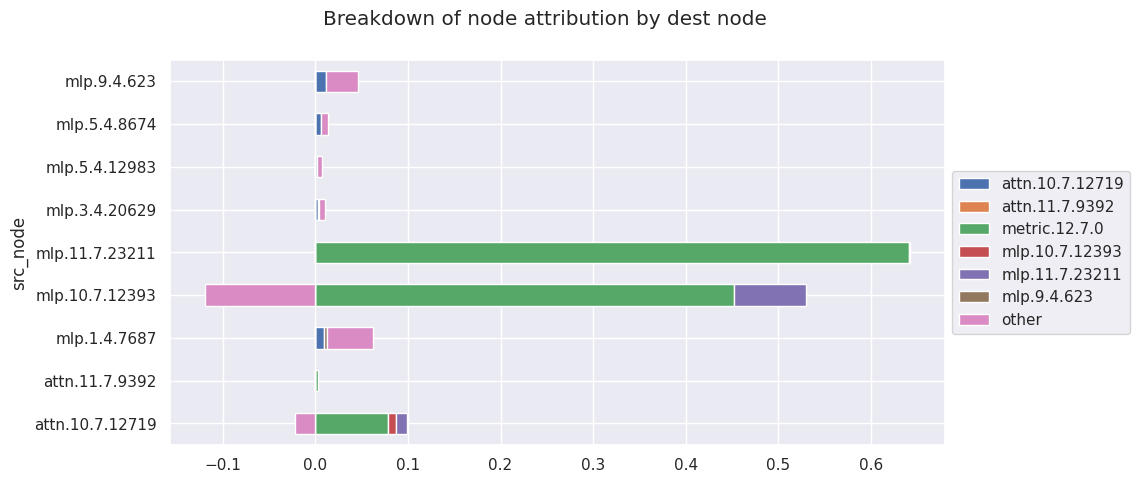

In [177]:
pivot_df = partial_attrib_df.pivot_table(index='src_node', columns='dest_node', values='partial_attrib', fill_value=0)


fig, ax = plt.subplots(figsize = (10, 5))
pivot_df.plot(kind='barh', stacked=True, ax = ax)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
fig.suptitle("Breakdown of node attribution by dest node")

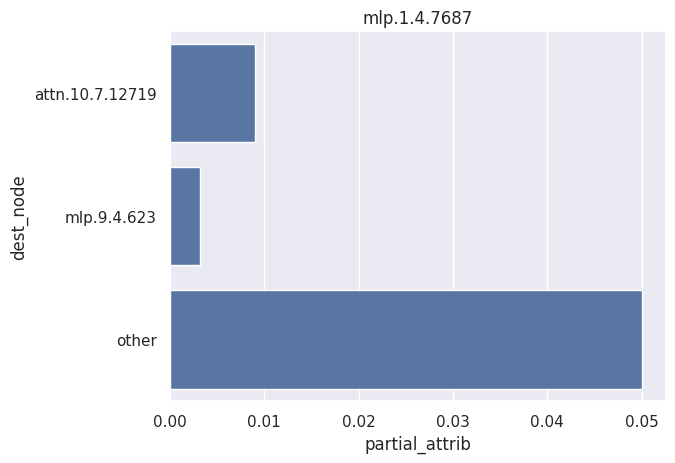

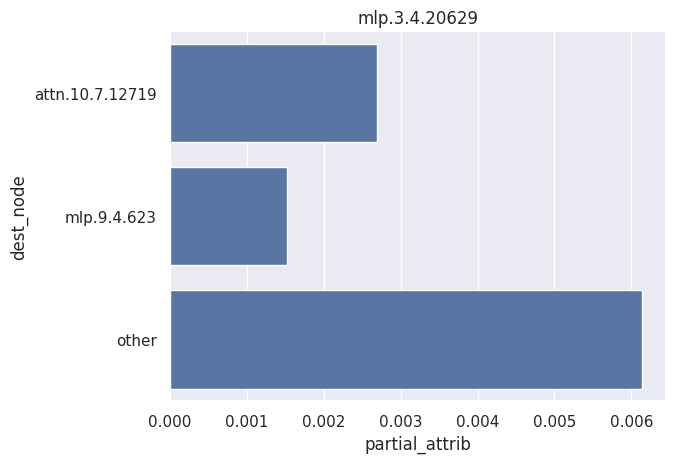

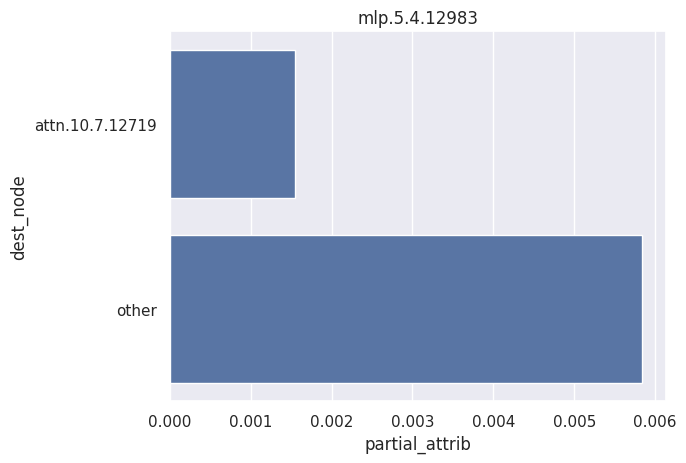

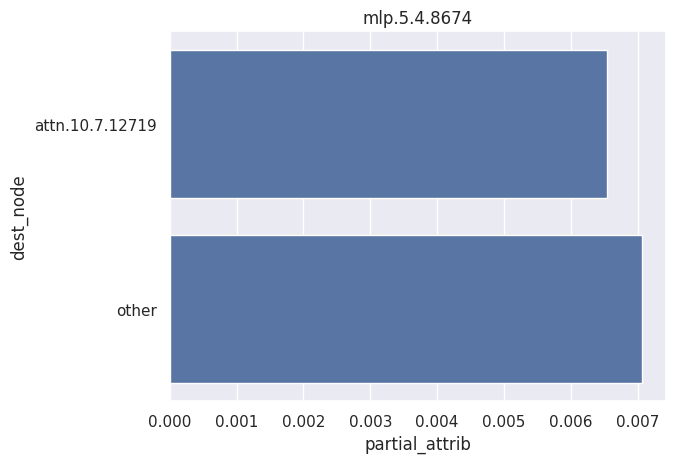

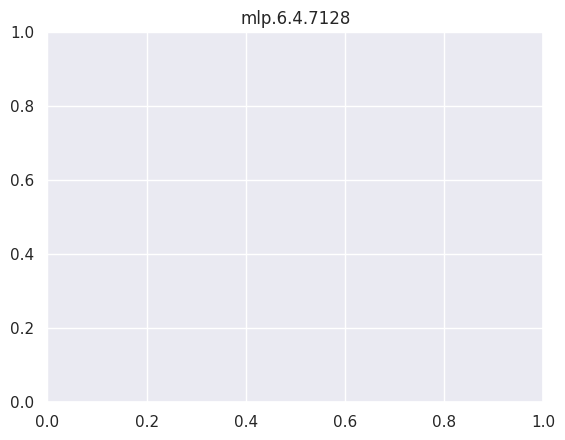

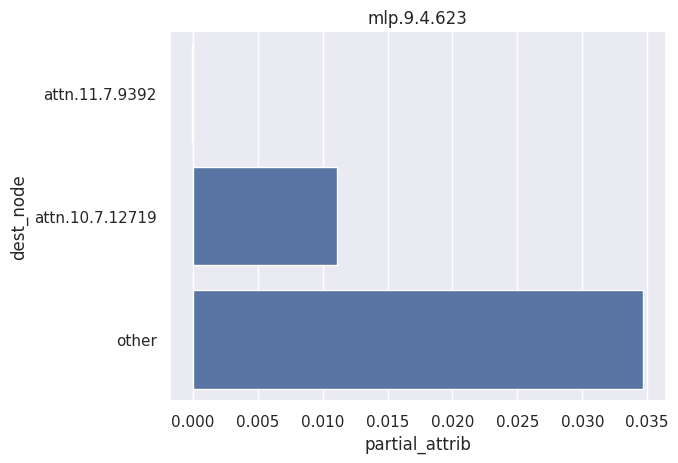

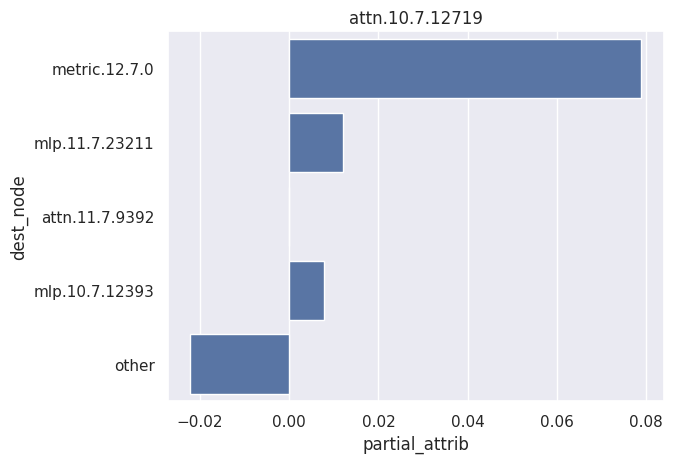

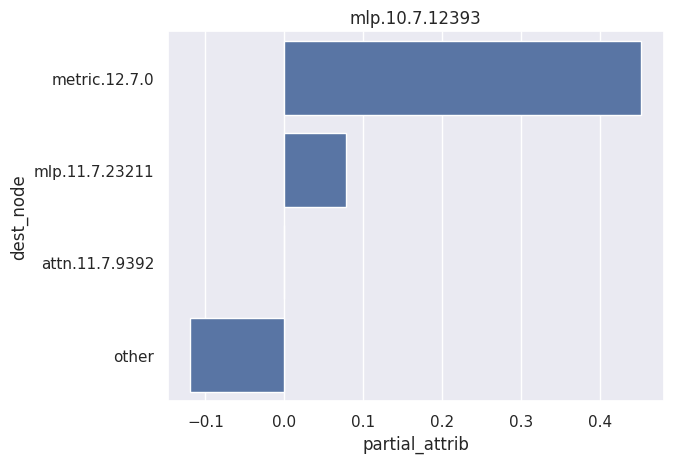

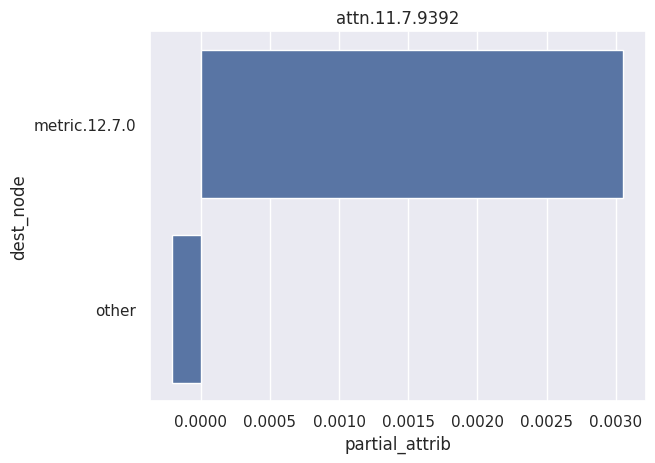

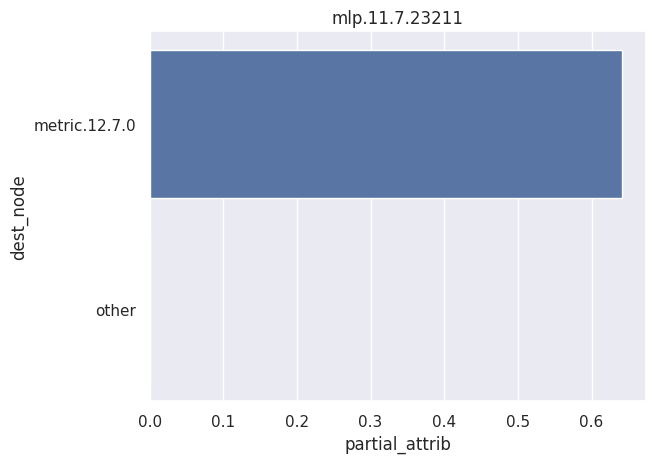

In [178]:
for name, node in nodes_of_interest.items():
    _df = partial_attrib_df[partial_attrib_df.src_node == node]
    fig, ax = plt.subplots()
    sns.barplot(_df, y = "dest_node", x = "partial_attrib")
    ax.set_title(node)